# Low-Rank Adaption of ViT-based Model for Image Segmentation

[[Paper](https://arxiv.org/abs/2106.09685)] [[Notebook](https://github.com/fastestimator/fastestimator/blob/master/apphub/foundation_model/lora/lora.ipynb)] [[TF Implementation](https://github.com/fastestimator/fastestimator/blob/master/apphub/foundation_model/lora/lora_tf.py)] [[Torch Implementation](https://github.com/fastestimator/fastestimator/blob/master/apphub/foundation_model/lora/lora_torch.py)]

Low-Rank Adaptation, also known as __LoRA__, is a popular method used for fine-tuning large-scale attention-based models. To see the benefits of LoRA, it's worthwhile to first take an overview of the conventional fine-tuning workflows:

1. Start from a pretrained network weight
2. Append new layers to the pretrained network
3. Train the new layers with one of the below options:
   1. Keep the pretrained weight frozen
   2. Train the pretrained weight together with new layers
  
No matter which one to choose, they both have their own limitations. A frozen pretrained weight often leads to a poorer fine-tuning performance, because the pretrained network is unable to adapt to the new task.  On the other hand, training everything together can significantly increase hardware requirments and slow down training. In recent days when large-scale model is becoming more and more common, training all parameters of large-scale model becomes almost impossible with our day-to-day hardware.

Then comes LoRA, to overcome these challenges. The core idea of LoRA is to insert a small number of parameters in an existing pretrained network such that the entire network can be fine-tuned through training only a small amount of parameters. In this example, we will walk through the implementation detail of LoRA with an image segmentation fine-tuning task.

## Getting things ready

First let's import the modules that are needed later for this example:

In [ ]:
import math
import os
import tempfile
from functools import partial
from typing import Any, Dict, List, Optional, Tuple, Type

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import kaiming_normal_ as he_normal

import fastestimator as fe
from fastestimator.backend import load_model
from fastestimator.dataset.data import montgomery
from fastestimator.op.numpyop import Delete, NumpyOp
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import ChannelTranspose, Minmax, ReadImage
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Dice
from fastestimator.util.google_download_util import download_file_from_google_drive
from fastestimator.util.util import get_num_gpus, get_num_devices


Next we will set up some hyper-parameters:

In [2]:
epochs = 1
batch_size_per_gpu = 2
train_steps_per_epoch = None
eval_steps_per_epoch = None
base_encoder_weights = "sam_b"
lora_weights = None
save_dir = tempfile.mkdtemp()
data_dir = None


## Data Loading for the Image Segmentation Task

In this example, we will use the Montgomery dataset for lung segmentation. The basic data loading setup should be almost the same as [this example](https://github.com/fastestimator/fastestimator/blob/master/apphub/semantic_segmentation/unet/unet.ipynb) except for one minor difference: The pretrained network architecture (SAM) requires the input image shape to be (3, 1024, 1024).

In [3]:
class CombineLeftRightMask(NumpyOp):
    """NumpyOp to combine left lung mask and right lung mask."""
    def forward(self, data: List[np.ndarray], state: Dict[str, Any]) -> List[np.ndarray]:
        mask_left, mask_right = data
        data = np.maximum(mask_left, mask_right)
        return data


ds_train = montgomery.load_data(root_dir=data_dir)
ds_eval = ds_train.split(0.2)
pipeline = fe.Pipeline(
    train_data=ds_train,
    eval_data=ds_eval,
    batch_size=get_num_devices() * batch_size_per_gpu,
    ops=[
        ReadImage(inputs="image", parent_path=ds_train.parent_path, outputs="image"),
        ReadImage(inputs="mask_left", parent_path=ds_train.parent_path, outputs="mask_left", color_flag='gray'),
        ReadImage(inputs="mask_right", parent_path=ds_train.parent_path, outputs="mask_right", color_flag='gray'),
        CombineLeftRightMask(inputs=("mask_left", "mask_right"), outputs="mask"),
        Resize(image_in="image", width=1024, height=1024),
        Resize(image_in="mask", width=1024, height=1024),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask"),
        ChannelTranspose(inputs=("image", "mask"), outputs=("image", "mask")),
        Delete(keys=("mask_left", "mask_right"))
    ])


Now let's visualize the data output by pipeline:

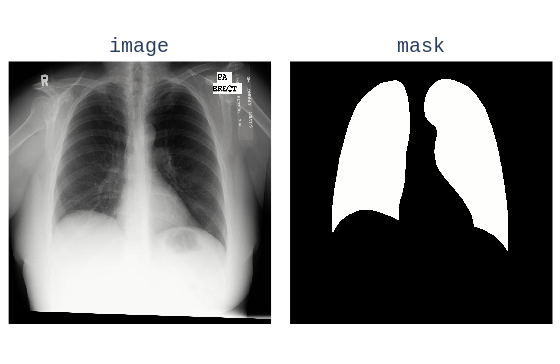

In [4]:
from fastestimator.util import ImageDisplay, GridDisplay

batch_data = pipeline.get_results()
batch_index = 0
GridDisplay([ImageDisplay(image=batch_data['image'][batch_index][0], title="image"),
             ImageDisplay(image=np.squeeze(batch_data['mask'][batch_index]), title="mask")
            ]).show(interactive=False)


## Defining Network and its LoRA parameters

Now we finally come to the fun part, defining models and LoRA parameters.  In this example, we will use a [SAM](https://arxiv.org/abs/2304.02643) encoder as the pre-trained weight, then add our own LoRA parameters to the encoder.

### SAM Encoder

First let's define the SAM encoder architecture, hang in there.

In [5]:

class ImageEncoderViT(nn.Module):
    def __init__(self,
                 img_size: int = 1024,
                 patch_size: int = 16,
                 in_chans: int = 3,
                 embed_dim: int = 768,
                 depth: int = 12,
                 num_heads: int = 12,
                 mlp_ratio: float = 4.0,
                 out_chans: int = 256,
                 qkv_bias: bool = True,
                 norm_layer: Type[nn.Module] = nn.LayerNorm,
                 act_layer: Type[nn.Module] = nn.GELU,
                 use_abs_pos: bool = True,
                 use_rel_pos: bool = False,
                 rel_pos_zero_init: bool = True,
                 window_size: int = 0,
                 global_attn_indexes: Tuple[int, ...] = ()) -> None:
        super().__init__()
        self.img_size = img_size
        self.patch_embed = PatchEmbed(kernel_size=(patch_size, patch_size),
                                      stride=(patch_size, patch_size),
                                      in_chans=in_chans,
                                      embed_dim=embed_dim)

        self.pos_embed: Optional[nn.Parameter] = None
        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(torch.zeros(1, img_size // patch_size, img_size // patch_size, embed_dim))

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(dim=embed_dim,
                          num_heads=num_heads,
                          mlp_ratio=mlp_ratio,
                          qkv_bias=qkv_bias,
                          norm_layer=norm_layer,
                          act_layer=act_layer,
                          use_rel_pos=use_rel_pos,
                          rel_pos_zero_init=rel_pos_zero_init,
                          window_size=window_size if i not in global_attn_indexes else 0,
                          input_size=(img_size // patch_size, img_size // patch_size))
            self.blocks.append(block)

        self.neck = nn.Sequential(nn.Conv2d(embed_dim, out_chans, kernel_size=1, bias=False),
                                  LayerNorm2d(out_chans),
                                  nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
                                  LayerNorm2d(out_chans))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.neck(x.permute(0, 3, 1, 2))
        return x


class Block(nn.Module):
    def __init__(self,
                 dim: int,
                 num_heads: int,
                 mlp_ratio: float = 4.0,
                 qkv_bias: bool = True,
                 norm_layer: Type[nn.Module] = nn.LayerNorm,
                 act_layer: Type[nn.Module] = nn.GELU,
                 use_rel_pos: bool = False,
                 rel_pos_zero_init: bool = True,
                 window_size: int = 0,
                 input_size: Optional[Tuple[int, int]] = None) -> None:
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim,
                              num_heads=num_heads,
                              qkv_bias=qkv_bias,
                              use_rel_pos=use_rel_pos,
                              rel_pos_zero_init=rel_pos_zero_init,
                              input_size=input_size if window_size == 0 else (window_size, window_size))

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)
        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, self.window_size)

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hw, (H, W))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim: int,
                 num_heads: int = 8,
                 qkv_bias: bool = True,
                 use_rel_pos: bool = False,
                 rel_pos_zero_init: bool = True,
                 input_size: Optional[Tuple[int, int]] = None) -> None:
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (input_size is not None), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.qkv(x).reshape(B, H * W, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, (H, W), (H, W))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, -1).permute(0, 2, 3, 1, 4).reshape(B, H, W, -1)
        x = self.proj(x)
        return x


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    B, H, W, C = x.shape
    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w
    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)


def window_unpartition(windows: torch.Tensor, window_size: int, pad_hw: Tuple[int, int],
                       hw: Tuple[int, int]) -> torch.Tensor:
    Hp, Wp = pad_hw
    H, W = hw
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)
    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x


def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(attn: torch.Tensor,
                           q: torch.Tensor,
                           rel_pos_h: torch.Tensor,
                           rel_pos_w: torch.Tensor,
                           q_size: Tuple[int, int],
                           k_size: Tuple[int, int]) -> torch.Tensor:
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]).view(
        B, q_h * q_w, k_h * k_w)

    return attn


class PatchEmbed(nn.Module):
    def __init__(self,
                 kernel_size: Tuple[int, int] = (16, 16),
                 stride: Tuple[int, int] = (16, 16),
                 padding: Tuple[int, int] = (0, 0),
                 in_chans: int = 3,
                 embed_dim: int = 768) -> None:
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x


class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int, mlp_dim: int, act: Type[nn.Module] = nn.GELU) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


def sam_encoder_b(weights_path=None) -> nn.Module:
    encoder = ImageEncoderViT(depth=12,
                              embed_dim=768,
                              img_size=1024,
                              mlp_ratio=4,
                              norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
                              num_heads=12,
                              patch_size=16,
                              qkv_bias=True,
                              use_rel_pos=True,
                              global_attn_indexes=(2, 5, 8, 11),
                              window_size=14,
                              out_chans=256)
    if weights_path not in [None, "None"]:
        print("Loading SAM Encoder weights from {}...".format(weights_path))
        load_model(encoder, weights_path=weights_path)
    return encoder


### LoRA parameters, and integrating into SAM models

The core idea of implementing LoRA parameters for attention-based network is to add additional dense layers to the existing dense layers associated with __Querry (Q)__ and __Value (V)__ in attention module. As a result, the new dense layer created by LoRA can modify the `Q` and `V` in all attention modules easily.

In addition, it is also suggested to implement additional functions for saving & Loading the LoRA weights only, such that we don't have to keep writing or loading the weights associated with large scale model to the disk.  The saving & loading functions are implemented as `load_lora_weights` and `save_lora_weights`.

In [6]:
class LoRA_SamEncoder(nn.Module):
    def __init__(self, r=4, base_encoder_weights=None, lora_weights=None):
        super().__init__()
        self.base_encoder = sam_encoder_b(weights_path=base_encoder_weights)
        # create for storage, then we can init them or load weights
        self.w_As = []  # These are linear layers
        self.w_Bs = []
        print('parameter number of image encoder: ' +
              str(sum(p.numel() for p in self.base_encoder.parameters() if p.requires_grad)))
        # lets freeze all image encoders
        for param in self.base_encoder.parameters():
            param.requires_grad = False
        lora_param_num = 0
        # Here, we do the surgery by replacing the qkv function of original attention
        for blk in self.base_encoder.blocks:
            w_qkv_linear = blk.attn.qkv
            dim = w_qkv_linear.in_features
            w_a_linear_q = nn.Linear(dim, r, bias=False)
            w_b_linear_q = nn.Linear(r, dim, bias=False)
            w_a_linear_v = nn.Linear(dim, r, bias=False)
            w_b_linear_v = nn.Linear(r, dim, bias=False)
            self.w_As.append(w_a_linear_q)
            self.w_Bs.append(w_b_linear_q)
            self.w_As.append(w_a_linear_v)
            self.w_Bs.append(w_b_linear_v)
            blk.attn.qkv = _LoRA_qkv(
                w_qkv_linear,
                w_a_linear_q,
                w_b_linear_q,
                w_a_linear_v,
                w_b_linear_v,
            )
            lora_param_num += sum(p.numel() for p in blk.attn.qkv.parameters() if p.requires_grad)
        print('parameter number of LoRA: ' + str(lora_param_num))
        self.lora_modules = nn.ModuleList(self.w_As + self.w_Bs)
        if lora_weights:
            self.load_lora_weights(lora_weights)
        else:
            self.init_lora_weights()

    def init_lora_weights(self):
        for w_A in self.w_As:
            nn.init.kaiming_uniform_(w_A.weight, a=math.sqrt(5))
        for w_B in self.w_Bs:
            nn.init.zeros_(w_B.weight)

    def forward(self, x):
        out = self.base_encoder(x)
        return out

    def load_lora_weights(self, save_path):
        print("Loading LoRA weights from {}...".format(save_path))
        self.lora_modules.load_state_dict(torch.load(save_path, map_location='cpu' if get_num_gpus() == 0 else None))

    def save_lora_weights(self, save_dir, name="lora"):
        save_path = os.path.join(save_dir, "{}.pt".format(name))
        print("Saving LoRA weights to {}...".format(save_path))
        torch.save(self.lora_modules.state_dict(), save_path)


class _LoRA_qkv(nn.Module):
    def __init__(self,
                 qkv: nn.Module,
                 linear_a_q: nn.Module,
                 linear_b_q: nn.Module,
                 linear_a_v: nn.Module,
                 linear_b_v: nn.Module):
        super().__init__()
        self.qkv = qkv
        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q
        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v
        self.dim = qkv.in_features

    def forward(self, x):
        qkv = self.qkv(x)  # B,N,N,3*org_C
        new_q = self.linear_b_q(self.linear_a_q(x))
        new_v = self.linear_b_v(self.linear_a_v(x))
        # only modify the Q and V
        qkv[:, :, :, :self.dim] += new_q
        qkv[:, :, :, -self.dim:] += new_v
        return qkv


### Segmentation Head (Decoder)

Now that we have the encoder infused with LoRA parameters, we still need another decoder to perform the segmetnation task. For this example, we simply use a Unet-like decoder for the task.

In [7]:
class UNetDecoderBlock(nn.Module):
    """A UNet decoder block.

    This class is intentionally not @traceable (models and layers are handled by a different process).

    Args:
        in_channels: How many channels enter the decoder.
        mid_channels: How many channels are used for the decoder's intermediate layer.
        out_channels: How many channels leave the decoder.
    """
    def __init__(self, in_channels: int, mid_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.GroupNorm(num_groups=8, num_channels=in_channels),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                                    nn.Upsample(scale_factor=2),
                                    nn.GroupNorm(num_groups=8, num_channels=mid_channels),
                                    nn.ReLU(),
                                    nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1))

        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class UNet_Decoder(nn.Module):
    def __init__(self, num_classes=1) -> None:
        super().__init__()
        self.dec4 = UNetDecoderBlock(in_channels=256, mid_channels=256, out_channels=128)  # 128
        self.dec3 = UNetDecoderBlock(in_channels=128, mid_channels=128, out_channels=64)  # 256
        self.dec2 = UNetDecoderBlock(in_channels=64, mid_channels=64, out_channels=64)  # 512
        self.dec1 = UNetDecoderBlock(in_channels=64, mid_channels=64, out_channels=32)  # 1024
        self.dec0 = nn.Sequential(nn.GroupNorm(num_groups=8, num_channels=32),
                                  nn.ReLU(),
                                  nn.Conv2d(32, 32, kernel_size=3, padding=1),
                                  nn.GroupNorm(num_groups=8, num_channels=32),
                                  nn.ReLU(),
                                  nn.Conv2d(32, num_classes, kernel_size=3, padding=1))

        for layer in self.dec0:
            if isinstance(layer, nn.Conv2d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dec4(x)
        x = self.dec3(x)
        x = self.dec2(x)
        x = self.dec1(x)
        x = self.dec0(x)
        x = torch.sigmoid(x) # if needed, can return logits for numerical stability
        return x


### Instantiating different models

Now that all the network pieces are defined, we can start creating different network instances.  As we can see, the trainable LoRA parameters only occupies ~ 0.1 % of the overall encoder parameters.

In [8]:
def download_sam_encoder_b(save_dir):
    weights_path = os.path.join(save_dir, "sam_encoder_b.pth")
    if not os.path.exists(weights_path):
        print("Downloading Sam Encoder-b's weight to {}...".format(weights_path))
        download_file_from_google_drive("1l88I5jImXHp7TgMFaopY-w4bGkLnLDce", destination=weights_path)
    return weights_path

# First we will download an existing SAM encoder weight and load it as a pre-trained weights.
if base_encoder_weights == "sam_b":
    base_encoder_weights = download_sam_encoder_b(save_dir)

encoder = fe.build(
    model_fn=lambda: LoRA_SamEncoder(base_encoder_weights=base_encoder_weights, lora_weights=lora_weights),
    optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-4),
    model_name="encoder")

decoder = fe.build(model_fn=UNet_Decoder, optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-4), model_name="decoder")


100%|███████████████████████████████████████████████████████████████████████████████| 359M/359M [00:34<00:00, 10.3MB/s]


Loading SAM Encoder weights from /tmp/tmpwg24ctfi/sam_encoder_b.pth...
parameter number of image encoder: 89670912
parameter number of LoRA: 147456


### Network Operations

The rest of the network operations are very intuitive: feed image to encoder to get embedding, then use embedding to decoder to get the predicted mask. The predicted mask and the ground truth mask are used to calculate loss. Finally, the loss will be back-propagated back to decoder and LoRA parameters of encoder.

In [9]:
network = fe.Network(ops=[
    ModelOp(model=encoder, inputs="image", outputs="feature_embedding"),
    ModelOp(model=decoder, inputs="feature_embedding", outputs="mask_pred"),
    CrossEntropy(inputs=("mask_pred", "mask"), outputs="loss", form="binary"),
    UpdateOp(model=decoder, loss_name="loss"),
    UpdateOp(model=encoder, loss_name="loss")
])


# Prepare the training

During the training, we will monitor the Dice score on evaluation set to measure how good the segmentation is. 

In addition, we can customize `BestLoRASaver` Trace that can save the LoRA parameters regularly. This is done by overriding the model saving behavior of `BestModelSaver` such that we only save the LoRA weights instead of the whole network.

In [10]:
class BestLoRASaver(BestModelSaver):
    def on_epoch_end(self, data) -> None:
        if self.monitor_op(data[self.metric], self.best):
            self.best = data[self.metric]
            self.since_best = 0
            if self.save_dir:
                if isinstance(self.model, torch.nn.DataParallel):
                    self.model_path = self.model.module.save_lora_weights(self.save_dir, self.model_name + "_lora")
                else:
                    self.model_path = self.model.save_lora_weights(self.save_dir, self.model_name + "_lora")
        else:
            self.since_best += 1
        data.write_with_log(self.outputs[0], self.since_best)
        data.write_with_log(self.outputs[1], self.best)


traces = [
    Dice(true_key="mask", pred_key="mask_pred"),
    BestModelSaver(model=decoder, save_dir=save_dir, metric='Dice', save_best_mode='max'),
    BestLoRASaver(model=encoder, save_dir=save_dir, metric="Dice", save_best_mode="max")
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=epochs,
                         log_steps=20,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)


# Let the training begin...

To see the benefits of LoRA and our SAM pre-trained weight, we only train for __1__ epoch, aka ~100 images, and measure its evaluation Dice score. 

In [11]:
estimator.fit()


FastEstimator-Warn: Expected PyTorch version 2.0.1 but found 2.0.0+cu118. The framework may not work as expected.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 20; num_device: 1;
FastEstimator-Train: step: 1; loss: 0.6652049;
FastEstimator-Train: step: 20; loss: 0.14736064; steps/sec: 1.8;
FastEstimator-Train: step: 40; loss: 0.10255476; steps/sec: 1.77;
FastEstimator-Train: step: 55; epoch: 1; epoch_time(sec): 38.12;
Eval Progress: 1/14;
Eval Progress: 4/14; steps/sec: 1.35;
Eval Progress: 9/14; steps/sec: 2.01;
Eval Progress: 14/14; steps/sec: 2.0;
Fa

With only one epoch of training, the network can reaches 95% Dice score on the evaluation set. Comparing this number with the number we get from [this example](https://github.com/fastestimator/fastestimator/blob/master/apphub/semantic_segmentation/unet/unet.ipynb), we can tell the convergence is much better thanks to LoRA and SAM.

# Inferencing

To see the effect of our LoRA fine-tuning, let's perform inferencing on eval set and visualize its result:

In [12]:
data = pipeline.get_results(mode="eval")
data = network.transform(data=data, mode="eval")


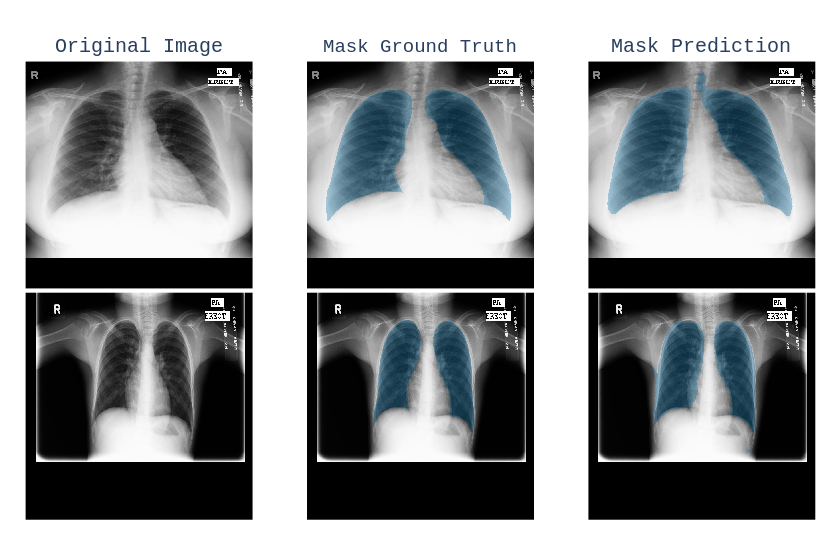

In [13]:
from fastestimator.util import BatchDisplay

GridDisplay([BatchDisplay(image=data['image'], title="Original Image"),
             BatchDisplay(image=data['image'], masks=data['mask'], mask_threshold=0.5, title="Mask Ground Truth"),
             BatchDisplay(image=data['image'], masks=data['mask_pred'], mask_threshold=0.5, title="Mask Prediction")]).show(interactive=False)
